# A simple program for calculating cw signal-to-noise ratio in PTA data

$
(S/N)^2 = 2 \langle \ln \Lambda \rangle = \sum_{i=1}^{N_p} (S_i|S_i),
$

**where**:

$
(S_i|S_i) = S_i^T G (G^T C G)^{-1} G^{T} S_i,
$

$
C = N + T B T^T,
$

$
M = [G_c G] \begin{bmatrix}
            S & 0\\
            0 & 0
            \end{bmatrix} V^T,
$

$N$ : wihte noise cov martix.

$T$ : design martix collection for GP basis.

$B$ : GP prior matrix.

$M$ : design matrix.


In [1]:
import json
import glob
import pickle
import warnings
import time

import numpy as np
from enterprise.signals import signal_base
from enterprise.pulsar import Pulsar
from enterprise_extensions.frequentist import optimal_statistic as OS
from enterprise_extensions import deterministic as det

from pptadr3models import getnoise_dict, dr3models

Optional mpi4py package is not installed.  MPI support is not available.


noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise dict pulsar name analysis
noise di

## load pulsar and noisedict

In [2]:
datadir = "/home/zhaosy/project/CW/PPTA-DR3/analysis_codes/data/all"
with open(datadir + "/30psrs.pkl", "rb") as pf:
    psrs = pickle.load(pf)

with open(datadir + "/noisedict.json", "r") as nf:
    noisedict = json.load(nf)

## load signal coloction for each pulsar

- You must make sure that the list of signals corresponds to the list of pulsars

In [5]:
models = dr3models(psrs, state="search", marg_tm=False, include_cw=False, model="signal_models")

HERE J0437-4715 UWL_PDFB4_20CM 260
HERE J0437-4715 UWL_sbA 303
HERE J0437-4715 UWL_sbG 532
HERE J0437-4715 CASPSR_40CM 331
HERE J0437-4715 UWL_PDFB4_20CM 260
HERE J0437-4715 UWL_sbA 303
HERE J0437-4715 UWL_sbG 532
HERE J0437-4715 CASPSR_40CM 331
HERE J0437-4715 PDFB_20CM 3400
TSpan is 5347.551 days
Fundamental frequency is 2.16e-09 Hz
the max Tspan of selection pulsar is 14.640796148551145 yr
getting prior for J0437-4715_red_noise_log10_A
found log10_A_min = -18.0, log10_A_max = -12.844964558674407
found gamma_min = 0.9322503347101001, gamma_max = 7.0
J0437-4715_red_noise_noise prior:
    log10_A in [-18.0, -12.844964558674407]
    gamma in [0.9322503347101001, 7.0]
    
Using 22 red noise components
getting prior for J0437-4715_hf_noise_log10_A
found log10_A_min = -16.58510224015062, log10_A_max = -12.872410280465129
found gamma_min = 0.0, gamma_max = 2.3560231378555647
J0437-4715_hf_noise_noise prior:
    log10_A in [-16.58510224015062, -12.872410280465129]
    gamma in [0.0, 2.35602

## Calculate the signal-to-noise ratio

- **function cw_residual:** product a cw signal list.

- **function get_snr:** Calculate cw signal-to-noise ratio for a specific pta.

In [6]:
def cw_residual(num, psr, 
                cos_gwtheta = None,
                gwphi       = None,
                cos_inc     = None,
                log10_mc    = None,
                log10_fgw   = None,
                log10_dist  = None,
                phase0      = None,
                psi         = None):
    """
    params note:
    :num: number of inject cw
    :psr: a enterprise pulsar object

    return:
    a list of cw residual
    """
    
    def get_value(param, name, low, high):
        """fix or random params"""
        return np.random.uniform(low, high) if param is None else param

    rrlst = []
    for _ in range(num):
        current_cos_gwtheta = get_value(cos_gwtheta, "cos_gwtheta", -1, 1)
        current_gwphi       = get_value(gwphi, "gwphi", 0, 2 * np.pi)
        current_cos_inc     = get_value(cos_inc, "cos_inc", -1, 1)
        current_log10_mc    = get_value(log10_mc, "log10_mc", 7, 10)
        current_log10_fgw   = get_value(log10_fgw, "log10_fgw", -9, -7.7)
        current_log10_dist  = get_value(log10_dist, "log10_dist", 1.5, 2.5)
        current_phase0      = get_value(phase0, "phase0", 0, 2 * np.pi)
        current_psi         = get_value(psi, "psi", 0, np.pi)

        params_dir = {
            "cos_gwtheta": current_cos_gwtheta,
            "gwphi": current_gwphi,
            "cos_inc": current_cos_inc,
            "log10_mc": current_log10_mc,
            "log10_fgw": current_log10_fgw,
            "log10_dist": current_log10_dist,
            "phase0": current_phase0,
            "psi": current_psi
        }

        """cw residual"""
        rr = det.cw_delay(psr.toas, psr.pos, psr.pdist,
                          psrTerm=False, p_dist=1, p_phase=None,
                          evolve=False, phase_approx=False, check=False,
                          tref=psr.toas.min(), **params_dir)
        rrlst.append(rr)

    return rrlst

def get_snr(num_inject, psrs, models, noisedict, mean_snr=True, **cw_params):

    """
    params:
    :num_inject: number of inject cw
    :psrs: a list of enterprise pulsar object
    :models: a list of enterprise signalcollection object
    :noisedict: 
    :mean_snr: if True get mean snr, else get PDF
    :cw_params: cos_gwtheta, gwphi, cos_inc, log10_mc, log10_fgw, log10_h, phase0, psi

    :return: 
    a dict: {psrname: snr}
    """

    if mean_snr:
        SNR = {psr.name: 0. for psr in psrs}
    else:
        SNR = {psr.name: [] for psr in psrs}

    def get_G(psr): 
        """The G matrix is obtained by svd decomposition of the design matrix."""
        M = psr.Mmat
        n = M.shape[1]
        U, _, _ = np.linalg.svd(M)
        G = U[:, n:]
        return n, G

    for ii, p in enumerate(psrs):

        res_lst = cw_residual(num_inject, p, **cw_params)

        pta  = signal_base.PTA(models[ii](p))
        n, G = get_G(p)  # G-martix
        N    = np.diag(pta.get_ndiag(noisedict)[0])  # white noise cov-martix
        B    = np.diag(pta.get_phi(noisedict)[0][n: ])  # GP prior martix
        T    = pta.get_basis()[0][:, n:]  # design martix collection

        C    = N + np.dot(np.dot(T, B), T.T)  # cov-martix
        G_GT = np.dot(np.dot(G, np.linalg.inv(np.dot(np.dot(G.T, C), G))), G.T)

        for ii, res in enumerate(res_lst):
            snr = np.dot(np.dot(res.T, G_GT), res)  # (S_i|S_i)
            if mean_snr:
                SNR[p.name] += (snr / num_inject)
            else:
                SNR[p.name].append(snr)

        print(f"SNR of {p.name}: {SNR[p.name]}")
        
    return SNR

In [7]:
snr_0437 = get_snr(10000, psr_0437, models, noise_0437, mean_snr=False, log10_mc=9, log10_fgw=-8, log10_dist=2)

HERE! Using 105 components
HERE! Using 45 components
HERE! Using 38 components
HERE! Using 40 components
SNR of J0437-4715: [6.705185525529937, 1.762219080562719, 0.011129886431707042, 0.009232833989514834, 0.008117389947985774, 0.0010110209831900002, 4.692334456249398, 0.8150629522722199, 1.098539975426039, 0.00857068104083948, 0.43470776119358356, 0.04200045884305581, 0.006674718983558069, 0.852710769273704, 0.18736070425837958, 0.14478923640131802, 0.020677855906265565, 1.908725190497153, 3.3450539549102842, 0.033212289070627156, 2.195379623085126, 0.7475138258255601, 1.5370463793023728, 1.656629115742202, 0.0831846684946055, 0.005321193431026472, 0.3141240998769135, 1.144667272862546, 2.1117181758310983, 0.7770247392885357, 3.4475378753934085, 0.04434455057765086, 2.6099958955102704, 0.26150178726699685, 1.606228310653483, 1.8599837639465069, 0.26702749423083294, 0.18619599849706592, 0.9435716790220084, 0.6218669754906478, 0.8116736725260781, 1.709499177895219, 1.2370465769253638, 

In [8]:
snr = sorted(snr_0437["J0437-4715"])
snr

[1.7422664037211765e-07,
 8.881240657766629e-07,
 1.1820784818355074e-06,
 2.9241381827118222e-06,
 3.278422073941504e-06,
 3.894461048757159e-06,
 4.047240871764764e-06,
 4.2328575649378005e-06,
 6.098040220971808e-06,
 6.617579527671323e-06,
 6.719323823318932e-06,
 6.980620471427301e-06,
 7.1058621264564255e-06,
 7.22177851040488e-06,
 8.37478368649922e-06,
 9.628817088246173e-06,
 1.2264598958297104e-05,
 1.254255994657875e-05,
 1.5116309122877868e-05,
 2.122415005849645e-05,
 2.527943998660288e-05,
 2.5287419418292072e-05,
 2.552116739408004e-05,
 2.614683726242727e-05,
 2.633791673248068e-05,
 2.7794425911147525e-05,
 3.1836347908824245e-05,
 3.1894018119845586e-05,
 3.2288527087908604e-05,
 3.253894718284171e-05,
 3.386008357570346e-05,
 3.464912407445415e-05,
 3.7224367263487425e-05,
 3.828874484254622e-05,
 3.863429183134317e-05,
 4.337225234836404e-05,
 4.4803557765290176e-05,
 4.5996070719534034e-05,
 4.812524498853253e-05,
 5.0549359703878384e-05,
 5.0922002565290724e-05,
 

Text(0, 0.5, 'pdf')

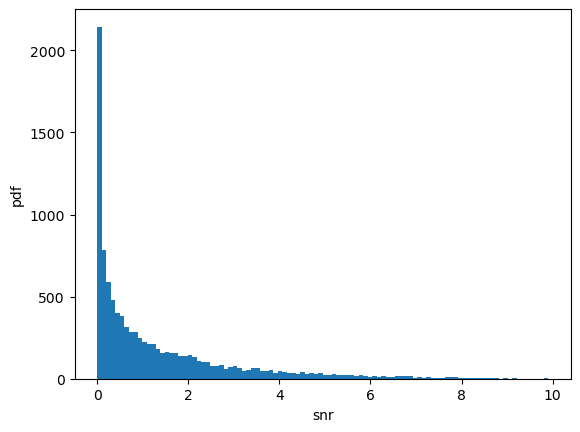

In [12]:
import matplotlib.pyplot as plt

plt.hist(snr, bins=100)
plt.xlabel("snr")
plt.ylabel("pdf")